# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
# ! pip install skimpy
# ! pip install pandas-profiling

from skimpy import clean_columns
import ydata_profiling
import time

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

## Подготовка данных

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В датафрейме имеем:

- `'DateCrawled'` — дата скачивания анкеты из базы
- `'VehicleType'` — тип автомобильного кузова
- `'RegistrationYear'` — год регистрации автомобиля
- `'Gearbox'` — тип коробки передач
- `'Power'` — мощность (л. с.)
- `'Model'` — модель автомобиля
- `'Kilometer'` — пробег (км)
- `'RegistrationMonth'` — месяц регистрации автомобиля
- `'FuelType'` — тип топлива
- `'Brand'` — марка автомобиля
- `'Repaired'` — была машина в ремонте или нет
- `'DateCreated'` — дата создания анкеты
- `'NumberOfPictures'` — количество фотографий автомобиля
- `'PostalCode'` — почтовый индекс владельца анкеты (пользователя)
- `'LastSeen'` — дата последней активности пользователя
- `'Price'` — цена (евро)

Представим названия колонок в виде snake_case с помощью `skimpy`

In [3]:
df = clean_columns(df)
df.head()

16 column names have been cleaned

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [5]:
df.isna().sum() / len(df) *100

date_crawled           0.000000
price                  0.000000
vehicle_type          10.579368
registration_year      0.000000
gearbox                5.596709
power                  0.000000
model                  5.560588
kilometer              0.000000
registration_month     0.000000
fuel_type              9.282697
brand                  0.000000
repaired              20.079070
date_created           0.000000
number_of_pictures     0.000000
postal_code            0.000000
last_seen              0.000000
dtype: float64

Проведем предварительный анализ с помощью `pandas_profiling`

In [6]:
# profile = df.profile_report(progress_bar=True)
# profile.to_widgets()

Замечаем:
- `'price'` e 3% данных нулевая цена, что странно. Максимальная цена 20000т руб.
- в колонке типа кузова `'vehicle_type'` 10.6% пропусков. Разделяются (по мере уменьшения численности): 'седаны', 'компактные авто', 'фургоны', 'автобусы', 'с откидной крышей', 'купе', 'кроссоверы' и 'другие'.
- приведены авто с годами регистрации `'registration_year'` от 1000 (чего???) до 9999 (как???). Необходимо прояснить этот момент.
- колонка `'gearbox'` имеет две категории: `manual` (ручная) и `auto`. Также имеется 5.6% пропусков
- в колонке мощность, несмотря на отсутствие пропусков, имеются 11.4% авто с нулевой мощностью (что очень странно). Максимальная мощность 20000 л.с. (еще страннее)
- в `'model'` имеется 5.6% пропусков.
- представлены преимущественно авто с пробегом (среднее значение 128211 км. максимальное - 150000 км). Хотя имеются и новые авто
- в `'fuel_type'` имеется 9.3% процента пропусков. Наиболее популярны авто на бензине и на газу.
- Топ 5 наиболее популярных брендов: Volkswagen, Opel, BMW, Mercedes_Benz и Audi (одни немцы).
- 20% пропусков в колонке `'repaired'`. Будем считать, что пропуск у авто, не учавствовашие в ремонте

In [7]:
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d').dt.year
df['date_created'].describe()

count    354369.000000
mean       2015.999924
std           0.009046
min        2014.000000
25%        2016.000000
50%        2016.000000
75%        2016.000000
max        2016.000000
Name: date_created, dtype: float64

Последнее объявление разместились в 2016 году

In [8]:
df[df['registration_year'] > 2016]['registration_year'].value_counts()

2017    10441
2018     3959
9999       26
2019       25
5000       17
3000        7
6000        5
7000        4
2500        4
4000        3
9000        3
8000        2
4500        2
5911        2
2222        2
5555        2
2800        2
7800        1
8455        1
9229        1
9996        1
7100        1
8200        1
5600        1
7500        1
9450        1
3700        1
2290        1
6500        1
4800        1
3800        1
8500        1
5900        1
2900        1
5300        1
2066        1
4100        1
2200        1
8888        1
3200        1
3500        1
Name: registration_year, dtype: int64

Выяснилось, что существует большое количество авто, год регистрации которых превышает год публикации, что странно. Причины этого стоит обсудить с заказчиком, предоставивший данные. Самая реалистичная последняя дата - 2019 год. Все авто, у которых год регистрации превышает 2019 год, `'registration_month'` приравняем к 2019 году.

In [9]:
df.loc[df['registration_year'] >= 2019, 'registration_year'] = 2019

In [10]:
df['registration_year'].describe()

count    354369.000000
mean       2002.936566
std          13.977028
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: registration_year, dtype: float64

In [11]:
df['registration_year'].quantile(0.005)

1971.0

In [12]:
len(df[df['registration_year'] < df['registration_year'].quantile(0.01)]) / len(df) *100

0.9741258405786059

Удалим авто с датой регистрации выше 1971 года (0.005 квантиль)

In [13]:
df = df.loc[df['registration_year'] >= df['registration_year'].quantile(0.005)]

In [14]:
df.duplicated().sum()

4

Удалим дубликаты

In [15]:
df = df.drop_duplicates()

Сразу удалим те столбцы, от которых цена авто не зависит. Это:
- `'date_crawled'` — дата скачивания анкеты из базы
- `'registration_month'` — месяц регистрации автомобиля. Достаточно года
- `'date_created'` — дата создания анкеты
- `'number_of_pictures'` — количество фотографий автомобиля
- `'postal_code'` — почтовый индекс владельца анкеты (пользователя)
- `'last_seen'` — дата последней активности пользователя

In [16]:
ml = df.drop(columns=['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'])
ml.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Неинформативные признаки определены верно

У одних и тех же моделей авто могут быть разные типы корпусов. Пуречислять пропуски к `'other'` означает исключение других типов корпусов. Поэтому заполним пропуски значением 'no_info'.
Пропуски в колонке с ремонтом заполним `False`- ремонта не было

In [17]:
ml['vehicle_type'] = ml['vehicle_type'].fillna('no_info')
ml['repaired'] = ml['repaired'].fillna('no')

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
На мой скромный взгляд, заполнять ремонт тоже лучше заглушкой (ведь владелец может просто скрывать факт ремонта), но и заглушка, и мода - разумные методы заполнения категориальных признаков.

In [18]:
ml['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

У электрических и гибридных авто не может быть механическая коробка передач. Заполним их 'auto'

In [19]:
ml.loc[(ml['gearbox'].isna()) & ((ml['fuel_type'] == 'electric') | (ml['fuel_type'] == 'hybrid')), 'gearbox'] = ml.loc[(ml['gearbox'].isna()) & ((ml['fuel_type'] == 'electric') | (ml['fuel_type'] == 'hybrid')), 'gearbox'].fillna('auto')

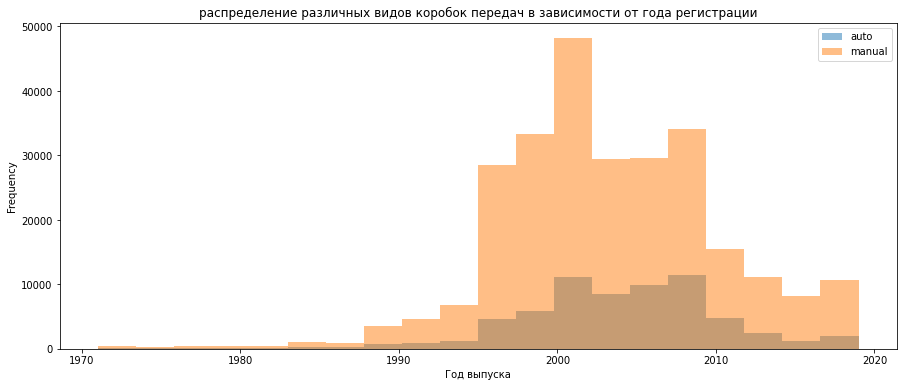

In [20]:
plt.figure(figsize=(15, 6))
ml.loc[(ml['gearbox'] == 'auto'), 'registration_year'].plot(alpha=0.5, bins=20, legend=True, kind='hist', label='auto')
ml.loc[(ml['gearbox'] == 'manual'), 'registration_year'].plot(alpha=0.5, bins=20, legend=True, kind='hist', label='manual')
plt.title('распределение различных видов коробок передач в зависимости от года регистрации')
plt.xlabel('Год выпуска');

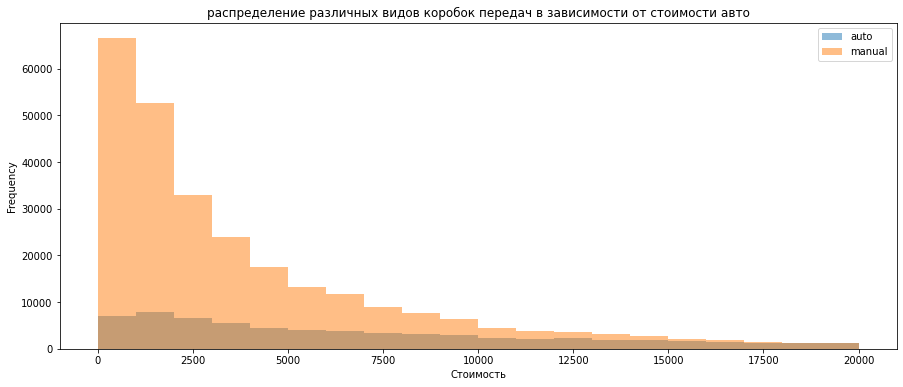

In [21]:
plt.figure(figsize=(15, 6))
ml.loc[(ml['gearbox'] == 'auto'), 'price'].plot(alpha=0.5, bins=20, legend=True, kind='hist', label='auto')
ml.loc[(ml['gearbox'] == 'manual'), 'price'].plot(alpha=0.5, bins=20, legend=True, kind='hist', label='manual')
plt.title('распределение различных видов коробок передач в зависимости от стоимости авто')
plt.xlabel('Стоимость');

Удивительно, что авто стоимостью более 15000т одинаковое количество на ручной и автоматической коробке передач. Поэтому заполним пропуски значением `manual`

In [22]:
ml['gearbox'] = ml['gearbox'].fillna('manual')

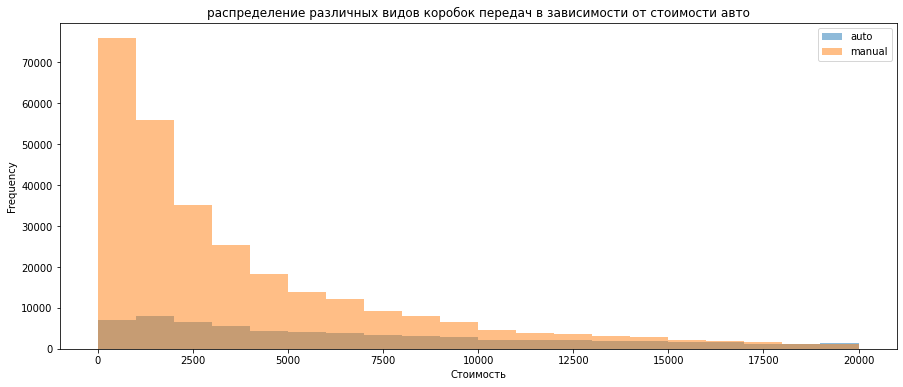

In [23]:
plt.figure(figsize=(15, 6))
ml.loc[(ml['gearbox'] == 'auto'), 'price'].plot(alpha=0.5, bins=20, legend=True, kind='hist', label='auto')
ml.loc[(ml['gearbox'] == 'manual'), 'price'].plot(alpha=0.5, bins=20, legend=True, kind='hist', label='manual')
plt.title('распределение различных видов коробок передач в зависимости от стоимости авто')
plt.xlabel('Стоимость');

На распределении это не отразилось

In [24]:
ml['power'].describe()

count    352694.000000
mean        110.279534
std         188.143562
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Предположим, что у некоторых авто с мощностью более 1000 л.с. ошибка в порядке величины. Исправим это, удалив данные свыше 0.995 квантиля

In [25]:
ml.loc[ml['power'] > 1000, 'power'] = ml.loc[ml['power'] > 1000, 'power'] / 10
ml.loc[ml['power'] > 1000, 'power'] = ml.loc[ml['power'] > 1000, 'power'] / 10
ml = ml[ml['power'] <= ml['power'].quantile(0.995)]

Нулевую мощность авто заменим на медианное значение мощности каждой модели

In [26]:
def add_median_power(df):
    median = df['power'].median()
    df.loc[df['power'] == 0, 'power'] = median
    df.loc[pd.isna(df['power']), 'power'] = median
    return df

ml = ml.groupby('model').apply(add_median_power)

ml.loc[(ml['model'] == 'samara') & (ml['power'] == 0), 'power'] = ml[(ml['model'] == 'samara') & (ml['power'] > 0)]['power'].median()
ml.loc[(ml['model'] == '911') & (ml['power'] == 0), 'power'] = ml[(ml['model'] == '911') & (ml['power'] > 0)]['power'].median()
ml.loc[(ml['model'] == 'serie_1') & (ml['power'] == 0), 'power'] = ml[(ml['model'] == 'serie_1') & (ml['power'] > 0)]['power'].median()
ml[ml['power'] == 0]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired


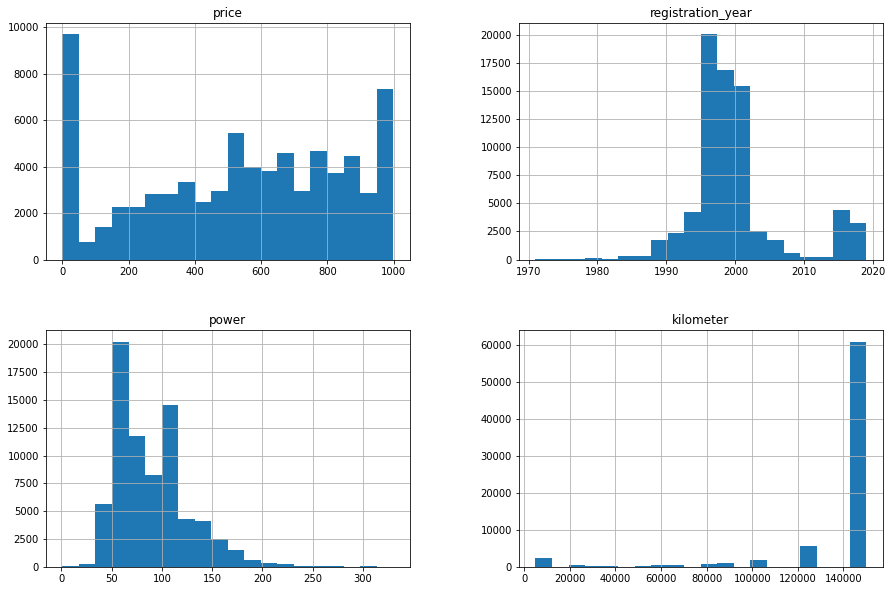

In [27]:
ml[ml['price'] < 1000].hist(bins=20, figsize=(15, 10));

У авто с нулевой ценой мощность также указана нулевая. Так как таких авто всего 3%, удалим их.

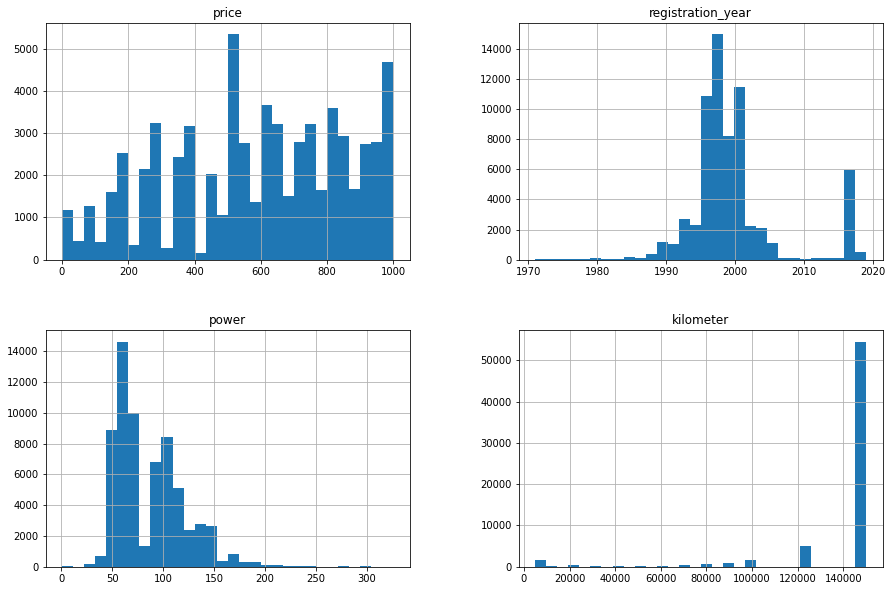

In [28]:
ml = ml[ml['price'] > ml['price'].quantile(0.005)]
ml[ml['price'] < 1000].hist(bins=30, figsize=(15, 10));

In [29]:
ml.isna().sum() / len(ml) *100

price                0.000000
vehicle_type         0.000000
registration_year    0.000000
gearbox              0.000000
power                0.000309
model                0.000000
kilometer            0.000000
fuel_type            7.174582
brand                0.000000
repaired             0.000000
dtype: float64

In [30]:
ml[ml['power'].isna()]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
234296,3800,wagon,1978,manual,NaN,serie_1,30000,gasoline,land_rover,no


In [31]:
ml = ml.dropna(subset='power')

In [32]:
ml['fuel_type'] = ml['fuel_type'].fillna('petrol')

In [33]:
# КОД РЕВЬЮЕРА
ml.duplicated().sum()

54653

In [34]:
ml = ml.drop_duplicates()

In [35]:
(354369 - len(ml)) / 354369 * 100

24.12118441511532

Таким образом по возможности заполнили пропуски. Удалили 24.12% даных.

Разделим данные на тестовую и обучающую выборки со стратификацией по `'model'`.

In [36]:
ml['model'].value_counts()

golf                  21397
other                 21119
3er                   15464
polo                   8993
astra                  8517
                      ...  
kalina                    7
rangerover                4
serie_2                   4
serie_3                   3
range_rover_evoque        1
Name: model, Length: 249, dtype: int64

In [37]:
ml[ml['model'] == 'range_rover_evoque']

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
31129,12500,suv,2005,auto,296.0,range_rover_evoque,150000,gasoline,land_rover,no


In [38]:
ml = ml.drop(labels = [31129],axis = 0)

In [39]:
ml[ml['model'] == 'range_rover_evoque']

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired


In [40]:
features = ml[ml.columns[1:]]
target = ml['price']

X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.25, 
                                                    random_state=42, 
                                                    stratify=features['model'])

Отмасштабируем численные признаки с помощью `StandardScaler`. 

In [41]:
scaler = StandardScaler()
# Обучаемся и трансформируем только численные признаки
scaler.fit(X_train[['kilometer', 'registration_year', 'power']])
X_train_scal = scaler.transform(X_train[['kilometer', 'registration_year', 'power']])
X_test_scal = scaler.transform(X_test[['kilometer', 'registration_year', 'power']])

# Создаем датасеты с отмасштабированными численными признаками
X_train_scal = pd.DataFrame(X_train_scal, index=X_train[['kilometer', 'registration_year', 'power']].index, columns=['kilometer', 'registration_year', 'power'])
X_test_scal = pd.DataFrame(X_test_scal, index=X_test[['kilometer', 'registration_year', 'power']].index, columns=['kilometer', 'registration_year', 'power'])

# Удаляем не отмасштабированные численные признаки из выборок
X_train = X_train.drop(['kilometer', 'registration_year', 'power'], axis=1)
X_test = X_test.drop(['kilometer', 'registration_year', 'power'], axis=1)

# Добавляем отмасштабированные численные признаки к выборкам
X_train = X_train.merge(X_train_scal, left_index=True, right_index=True)
X_test = X_test.merge(X_test_scal, left_index=True, right_index=True)

LightGBM и CatBoost умеют работать с категориальными признаками, однако модели линейной регрессии и случайного леса нет. Для них создадим отдельные выборки с применением `OneHotEncoder`.

In [42]:
X_train[X_train.columns[:-3]].nunique()

vehicle_type      9
gearbox           2
model           248
fuel_type         7
brand            39
repaired          2
dtype: int64

In [43]:
X_test[X_test.columns[:-3]].nunique()

vehicle_type      9
gearbox           2
model           248
fuel_type         7
brand            39
repaired          2
dtype: int64

In [44]:
ohe = OneHotEncoder(drop='first', sparse=False)
ohe.fit(X_train[X_test.columns[:-3]])
X_train_ohe = ohe.transform(X_train[X_test.columns[:-3]])
X_test_ohe = ohe.transform(X_test[X_test.columns[:-3]])

# Объединяем с численным массивом
X_train_ohe = np.hstack([X_train_ohe, np.array(X_train[X_test.columns[-3:]])])
X_test_ohe = np.hstack([X_test_ohe, np.array(X_test[X_test.columns[-3:]])])

## Обучение моделей

В работе будем обучать следующие модели:
- две модели градиентного бустинга (CatBoost и LightGBM)
- случайный лес
- линейная регрессия

Изменяемыми гиперпараметрами в моделях градиентного бустинга выступали:
- количество делевьев
- глубина дерева
- скорость обучения

Изменяемыми гиперпараметрами в модели случайного леса выступали:
- количество делевьев
- глубина дерева
- минимальное количество выборок, необходимое для разделения внутреннего узла
- минимальное количество выборок, необходимое для конечного узла

Для всех моделей применялась кросс-валидация м разделением на 5 выборок, оценивающаяся по RMSE. Для случайного леса и градиентного бустинга подбор гиперпараметров осуществлялся с помощью `RandomizedSearchCV`.
Для оценки качества моделей применим метрику RMSE.

С помощью атрибута `time()` будем замерать время обучения каждой модели, время предказания, а также RMSE кросс-валидации, RMSE на тестовой и обучающей выборках.

In [50]:
def grid_search_random(model, param, X_tr, y_tr):
    '''Функция подбора гиперпараметров с помощью RandomizedGridSearchCV.
       На входе принимает модель, словарь с гиперпараметрами, фичи и таргет.
       На выходе - словарь с лучшими гиперпараметрами'''
    
    grid = RandomizedSearchCV(model, param, n_jobs=-1, cv=5, 
                              scoring='neg_mean_squared_error',
                              random_state=42)
    grid.fit(X_tr, y_tr)
    best_score = (-grid.best_score_)**0.5
    print('RMSE кросс-валидации:', best_score)
    return best_score, grid.best_params_


def cat_boost(X_tr, y_tr, X_te, y_te, param):
    '''Функция cat_boost.
       На входе принимает фичи и таргеты обучающей и тестовой выборок.
       На выходе - оценка RMSE, время обучения и время предсказания'''
    print('=============== CatBoost ===============')
    start_train = time.time()
    clf = CatBoostRegressor(random_state=42, verbose=False, loss_function='RMSE')
    score_cv, m = grid_search_random(clf, param, X_tr, y_tr)
    clf = CatBoostRegressor(random_state=42,
                            verbose=False,
                            iterations=m['iterations'],
                            depth=m['depth'],
                            learning_rate=m['learning_rate'])
    clf.fit(X_tr, y_tr)
    end_train = time.time()
    print('RMSE на обучающей выборке:', mean_squared_error(clf.predict(X_tr), y_tr, squared=False))
    time_train = end_train - start_train
    print(f'Время обучения: {time_train:.2f} c')
    
    start_predict = time.time()
    predict = clf.predict(X_te)
    end_predict = time.time()
    time_predict = end_predict - start_predict
    print(f'Время предсказания: {time_predict:.2f} c')
    return score_cv, time_train, time_predict, m

def LGBM(X_tr, y_tr, X_te, y_te, param):
    '''Функция LightGBM.
       На входе принимает фичи и таргеты обучающей и тестовой выборок.
       На выходе - оценка RMSE, время обучения и время предсказания'''
    print('=============== LightGBM ===============')
    start_train = time.time()
    clf = LGBMRegressor(random_state=42, n_jobs=-1)
    score_cv, m = grid_search_random(clf, param, X_tr, y_tr)
    clf = LGBMRegressor(random_state=42,
                            n_jobs=-1,
                            n_estimators=m['n_estimators'],
                            max_depth=m['max_depth'],
                            learning_rate=m['learning_rate'])
    clf.fit(X_tr, y_tr)
    end_train = time.time()
    print('RMSE на обучающей выборке:', mean_squared_error(clf.predict(X_tr), y_tr, squared=False))
    time_train = end_train - start_train
    print(f'Время обучения: {time_train:.2f} c')
    
    start_predict = time.time()
    predict = clf.predict(X_te)
    end_predict = time.time()
    time_predict = end_predict - start_predict
    print(f'Время предсказания: {time_predict:.2f} c')
    return score_cv, time_train, time_predict, m

def random_forest_tree(X_tr, y_tr, X_te, y_te, param):
    '''Функция случайного леса.
       На входе принимает фичи и таргеты обучающей и тестовой выборок.
       На выходе - оценка RMSE, время обучения и время предсказания'''
    print('=============== случайный лес ===============')
    start_train = time.time()
    clf = RandomForestRegressor(random_state=42)
    score_cv, m = grid_search_random(clf, param, X_tr, y_tr)
    clf = RandomForestRegressor(random_state=42,
                                n_estimators=m['n_estimators'],
                                max_depth=m['max_depth'],
                                min_samples_split=m['min_samples_split'],
                                min_samples_leaf=m['min_samples_leaf'])
    clf.fit(X_tr, y_tr)
    end_train = time.time()
    print('RMSE на обучающей выборке:', mean_squared_error(clf.predict(X_tr), y_tr, squared=False))
    time_train = end_train - start_train
    print(f'Время обучения: {time_train:.2f} c')
    
    start_predict = time.time()
    predict = clf.predict(X_te)
    end_predict = time.time()
    time_predict = end_predict - start_predict
    print(f'Время предсказания: {time_predict:.2f} c')
    return score_cv, time_train, time_predict, m


def linear_regression(X_tr, y_tr, X_te, y_te):
    '''Функция линейной регрессии.
       На входе принимает фичи и таргеты обучающей и тестовой выборок.
       На выходе - оценка RMSE, время обучения и время предсказания'''
    print('=============== линейная регрессия ===============')
    start_train = time.time()
    clf = LinearRegression()
    scores = cross_val_score(clf, X_tr, y_tr, cv=5, scoring='neg_mean_squared_error')
    score_cv = (-scores.mean())**0.5
    print('RMSE кросс-валидации:', score_cv)
    clf.fit(X_tr, y_tr)
    end_train = time.time()
    time_train = end_train - start_train
    print('RMSE на обучающей выборке:', mean_squared_error(clf.predict(X_tr), y_tr, squared=False))
    print(f'Время обучения: {time_train:.2f} c')
    
    start_predict = time.time()
    predict = clf.predict(X_te)
    end_predict = time.time()
    time_predict = end_predict - start_predict
    print(f'Время предсказания: {time_predict:.2f} c')
    return score_cv, time_train, time_predict

In [46]:
rmse_cat_boost, time_train_cat_boost, time_predict_cat_boost, best_cat_boost = cat_boost(X_train_ohe, y_train, 
                                                                                         X_test_ohe, y_test,
                                                                                        {'iterations': range(4, 101, 4),
                                                                                         'depth': range(2, 11),
                                                                                         'learning_rate': np.arange(0, 1.1, 0.1)})

=============== CatBoost ===============
RMSE кросс-валидации: 1726.4703291131132
RMSE на обучающей выборке: 1623.936769379784
Время обучения: 825.52 c
Время предсказания: 4.39 c


In [47]:
rmse_LGBM, time_train_LGBM, time_predict_LGBM, best_LGBM = LGBM(X_train_ohe, y_train, X_test_ohe, y_test,
                                                                            {'n_estimators': range(4, 101, 4),
                                                                             'max_depth': range(2, 11),
                                                                             'learning_rate': np.arange(0, 1.1, 0.1)})

=============== LightGBM ===============
RMSE кросс-валидации: 1718.3729519235956
RMSE на обучающей выборке: 1654.1696537259215
Время обучения: 471.51 c
Время предсказания: 0.40 c


In [48]:
rmse_tree, time_train_tree, time_predict_tree, best_tree = random_forest_tree(X_train_ohe, y_train, X_test_ohe, y_test,
                                                                    {'n_estimators' : range(1, 101, 20),
                                                                     'max_depth' : range(1, 11),
                                                                     'min_samples_split' : range(2, 11, 2),
                                                                     'min_samples_leaf' : range(1, 11, 2)})

=============== случайный лес ===============
RMSE кросс-валидации: 1964.1011876650507
RMSE на обучающей выборке: 1909.9150806813677
Время обучения: 3413.95 c
Время предсказания: 0.60 c


In [51]:
rmse_linear, time_train_linear, time_predict_linear = linear_regression(X_train_ohe, y_train, X_test_ohe, y_test)

=============== линейная регрессия ===============
RMSE кросс-валидации: 2598.9753038739937
RMSE на обучающей выборке: 2592.6844045186654
Время обучения: 85.14 c
Время предсказания: 0.19 c


## Анализ моделей

In [52]:
table = pd.DataFrame({'CatBoost' : [rmse_cat_boost, time_train_cat_boost, time_predict_cat_boost], 
                            'LightGBM' : [rmse_LGBM, time_train_LGBM, time_predict_LGBM],
                            'decision_tree' : [rmse_tree, time_train_tree, time_predict_tree],
                            'linear' : [rmse_linear, time_train_linear, time_predict_linear]},
                            index=['RMSE_cv', 'time_train', 'time_predict']).T
table

,RMSE_cv,time_train,time_predict
CatBoost,1726.470329,825.519293,4.390032
LightGBM,1718.372952,471.511752,0.399626
decision_tree,1964.101188,3413.954047,0.601217
linear,2598.975304,85.137525,0.191653


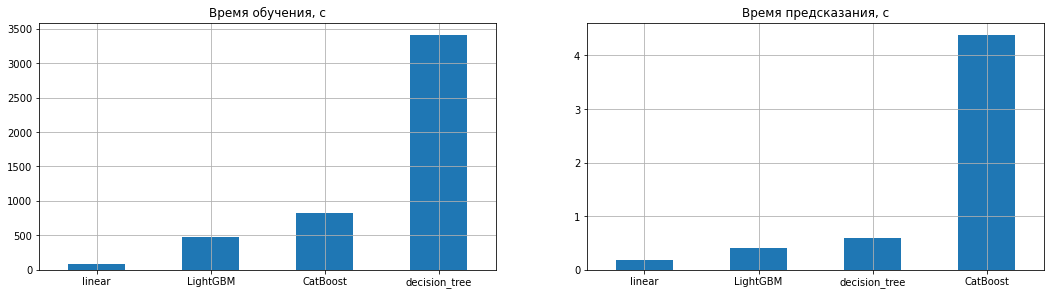

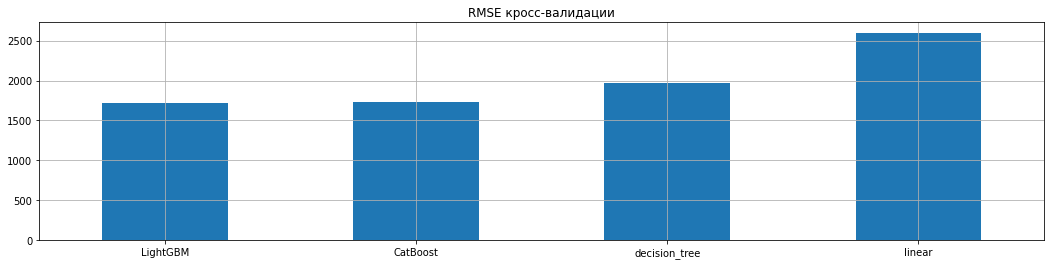

In [54]:
plt.figure(figsize=(18, 10))
plt.subplot(2, 2, 1)
table['time_train'].sort_values().plot(title='Время обучения, c', kind='bar', grid=True)
plt.xticks(rotation=0)
plt.subplot(2, 2, 2)
table['time_predict'].sort_values().plot(title='Время предсказания, c', kind='bar', grid=True)
plt.xticks(rotation=0)
plt.show()
table['RMSE_cv'].sort_values().plot(title='RMSE кросс-валидации', kind='bar', grid=True, figsize=(18, 4))
plt.xticks(rotation=0);

Самую низкую RMSE-оценку кросс-валидации, а также скорости обучения и предсказания дала модель LightGBM. RMSE-оценка кросс-валидации CatBoost несколько больше, однако скорость обучения и предсказания почти в 8 раз ниже LightGBM. Самое долгое обучение у случайного леса, однако предсказание у данной модели в 2 раза быстрее LightGBM. Самой быстрой моделью оказалась линейная регрессия, которая дала худшую RMSE-оценку кросс-валидации. Таким образом лучшей моделью для предсказания стоимости автомобиля из использованных является LightGBM.

In [56]:
best_LGBM

{'n_estimators': 84, 'max_depth': 9, 'learning_rate': 0.4}

In [55]:
clf = LGBMRegressor(random_state=42,
                            n_jobs=-1,
                            n_estimators=best_LGBM['n_estimators'],
                            max_depth=best_LGBM['max_depth'],
                            learning_rate=best_LGBM['learning_rate'])
clf.fit(X_train_ohe, y_train)
print('RMSE на тестовой выборке:', mean_squared_error(clf.predict(X_test_ohe), y_test, squared=False))

RMSE на тестовой выборке: 1680.3662746884302


Проверим предсказания на адекватность с помощью простейшей константной модели `DummyRegressor`

In [57]:
clf = DummyRegressor()
clf.fit(X_train_ohe, y_train)
predict_dummy = clf.predict(X_test_ohe)
rmse_dummy = mean_squared_error(predict_dummy, y_test, squared=False)
print('RMSE константной модели:', rmse_dummy)

RMSE константной модели: 4585.270306870105


Константная простейшая модель предсказывает цену автомобилей со значительно большей ошибкой. Это говорит об адекватности наших моделей и их оценке. В противном случае это бы означало, что любая рандомная модель могла предсказать целевую переменную лучше наших моделей.

Таким образом наилучшая модель - LightGBM - предсказывает цену автомобиля с RMSE ошибкой 1680.36.